###Instalacja bibliotek

In [ ]:
!pip install apache-beam[interactive]
# !pip install apache-beam[gcp]

In [ ]:
import apache_beam as beam
from apache_beam import pvalue
from apache_beam import Create, FlatMap, Map, ParDo, Flatten, Partition
from apache_beam import Values, CoGroupByKey
from apache_beam import pvalue, window, WindowInto
from apache_beam.transforms import trigger

from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib

import time
import random
from datetime import datetime

### ParDo

In [ ]:
class Square(beam.DoFn):
    def process(self, element):
        return [element**2]

with beam.Pipeline() as p:
    numbers = p | beam.Create([1, 2, 3, 4, 5])
    squared_numbers = numbers | beam.ParDo(Square())
    squared_numbers | 'Print output' >> beam.Map(print)

1
4
9
16
25


###Combine


In [ ]:
class AverageFn(beam.CombineFn):
    def create_accumulator(self):
        return (0.0, 0)  # tuple to store sum and count

    def add_input(self, accumulator, input):
        sum, count = accumulator
        return sum + input, count + 1

    def merge_accumulators(self, accumulators):
        sums, counts = zip(*accumulators)
        return sum(sums), sum(counts)

    def extract_output(self, accumulator):
        sum, count = accumulator
        return sum / count if count else float('NaN')

with beam.Pipeline() as p:
    numbers = p | beam.Create([1, 2, 3, 4, 5])
    average = numbers | beam.CombineGlobally(AverageFn())
    average | 'Print output' >> beam.Map(print)

3.0


###GroupByKey

In [ ]:
# Tworzenie pipeline'u
with beam.Pipeline() as pipeline:

    # Tworzenie PCollection z danymi wejściowymi
    input_data = pipeline | beam.Create([
        ('cat', 1), ('dog', 1), ('cat', 2), ('dog', 2), ('cat', 3)
    ])

    # Grupowanie danych wejściowych po kluczu
    grouped_data = input_data | beam.GroupByKey()

    # Wypisywanie wyników
    grouped_data | beam.Map(print)

('cat', [1, 2, 3])
('dog', [1, 2])


###CoGroupByKey

`CoGroupByKey` wykonuje relacyjne łączenie dwie lub więcej kolekcji `klucz/wartość` z tym samym typem klucza.

W tym przykładzie tworzymy dwie kolekcje - `"emails" i "phone_numbers"` - a następnie używamy funkcji `CoGroupByKey`, aby zgrupować je według klucza (`w tym przypadku imienia`). Wynik jest drukowany na konsoli przy użyciu funkcji `print_results`.

In [ ]:
with beam.Pipeline() as p:
    emails = p | 'Create emails' >> beam.Create([
        ('amy', 'amy@example.com'),
        ('carl', 'carl@example.com'),
        ('julia', 'julia@example.com'),
    ])
    phone_numbers = p | 'Create phone numbers' >> beam.Create([
        ('amy', '111-111-1111'),
        ('james', '222-222-2222'),
        ('carl', '333-333-3333'),
        ('julia', '444-444-4444'),
    ])

    results = ({'emails': emails, 'phone_numbers': phone_numbers}
               | beam.CoGroupByKey())

    def print_results(name_info):
        (name, info) = name_info

        emails = list(info['emails'])
        phone_numbers = list(info['phone_numbers'])
        print('{}: {} {}'.format(name, emails, phone_numbers))

    results | beam.Map(print_results)

    # Wypisywanie wyników
    # results | beam.Map(print)

amy: ['amy@example.com'] ['111-111-1111']
james: [] ['222-222-2222']
carl: ['carl@example.com'] ['333-333-3333']
julia: ['julia@example.com'] ['444-444-4444']


###Partition

`Partition` służy do zbierania obiektów przechowujących dane tego samego typu. Dzieli pojedynczą kolekcję na ustaloną liczbę mniejszych kolekcji.

W tym przykładzie definiujemy funkcję `"partition_fn"`, która zwraca `0`, jeśli element jest parzysty, lub `1`, jeśli jest nieparzysty.

Następnie tworzymy listę "data" i tworzymy `dwie puste listy`, które będą przechowywać podzbiory wynikowe. Przechodzimy przez wszystkie elementy w liście `"data"` i używamy funkcji `"partition_fn"` do przypisania każdego elementu do jednego z dwóch podzbiorów. Wynik końcowy jest listą dwóch podzbiorów, z których jeden zawiera wszystkie elementy parzyste, a drugi - wszystkie elementy nieparzyste. Na końcu drukujemy wynik na konsoli.

In [ ]:
def partition_fn(element, num_partitions):
    if element % 2 == 0:
        return 0
    else:
        return 1

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

partitioned_data = [[] for _ in range(2)]
for element in data:
    partition = partition_fn(element, 2)
    partitioned_data[partition].append(element)

print(partitioned_data)

[[2, 4, 6, 8, 10], [1, 3, 5, 7, 9]]


In [ ]:
# funkcja pomocnicza do utworzenia listy liczb
def create_list(n):
  return list(range(n))

# funkcja pomocnicza do wyświetlenia elementów PCollection
def print_elements(element):
  print(element)

# utworzenie pipeline
with beam.Pipeline() as p:
  # utworzenie PCollection z listą liczb
  numbers = p | 'Create numbers' >> beam.Create(create_list(10))

  # podział PCollection na dwie partycje
  partitions = numbers | 'Partition' >> beam.Partition(lambda x, y: x % 2, 2)

  # przetworzenie partycji
  processed_partitions = []

  for i in range(2):
    partition = partitions[i]
    processed_partition = (partition
      | f'Process partition {i}'
      >> beam.Map(lambda x: x * 2))
    processed_partitions.append(processed_partition)

  # złączenie przetworzonych partycji
  merged_partitions = (processed_partitions
    | 'Merge partitions' >> beam.Flatten())

  # wyświetlenie wyniku
  ib.show_graph(p)
  result = merged_partitions | 'Print result' >> beam.Map(print_elements)

0
4
8
12
16
2
6
10
14
18


###Flatten

In [ ]:
with beam.Pipeline() as p:
    pcoll1 = p | 'Create data 1' >> beam.Create([1, 2, 3])
    pcoll2 = p | 'Create data 2' >> beam.Create([4, 5, 6])
    pcoll3 = p | 'Create data 3' >> beam.Create([7, 8, 9])

    merged = (pcoll1, pcoll2, pcoll3) | 'Flatten' >> beam.Flatten()

    merged | 'Print Merged Data' >> beam.Map(print)

1
2
3
4
5
6
7
8
9


###Processing-Time Lag

`Processing-time lag` to mechanizm w bibliotece Apache Beam, który pozwala na opóźnienie przetwarzania danych w strumieniu, w celu umożliwienia przetwarzania w sposób opóźniony (tzn. z zadanym czasem opóźnienia) lub w celu ustawienia okna czasowego przetwarzania.

In [ ]:
class ProcessFn(beam.DoFn):
    def process(self, element):
        input_data = element

        # Pętla wykonująca 10000 obliczeń losowych liczb zmiennoprzecinkowych
        for i in range(10000):
            x = random.random()
            y = random.random()
            z = (x * x + y * y) ** 0.5

        return [input_data.upper()] # Zwrócenie danych wyjściowych

with beam.Pipeline() as pipeline:
    input = pipeline | beam.Create(["abc", "def", "ghi"])
    output = input | beam.ParDo(ProcessFn())

    output | 'Print Merged Data' >> beam.Map(print)

ABC
DEF
GHI


W tym kodzie, `input` reprezentuje strumień danych wejściowych, który jest przetwarzany przez funkcję `ParDo`. Wewnątrz klasy `ProcessFn`, funkcja `sleep` jest używana do zasymulowania opóźnienia przetwarzania. W tym przypadku, czas opóźnienia wynosi 5 sekund.

W tym kodzie, opóźnienie czasu przetwarzania `(processing-time lag)` występuje, ponieważ program czeka przez 5 sekund przed zakończeniem przetwarzania każdej danej wejściowej. W zależności od liczby danych wejściowych i czasu opóźnienia, to może spowodować znaczne opóźnienia w przetwarzaniu i wydłużyć czas całkowitego przetwarzania.

In [ ]:
class ProcessFn(beam.DoFn):
    def process(self, element):
        input_data = element

        # Symulacja opóźnienia przetwarzania
        time.sleep(5)

        return [input_data.upper()] # Zwrócenie danych wyjściowych

with beam.Pipeline() as pipeline:
    input = pipeline | beam.Create(["abc", "def", "ghi"])
    output = input | beam.ParDo(ProcessFn())

    output | 'Print Merged Data' >> beam.Map(print)

ABC
DEF
GHI


###Window

Dzieli `PCollection` zgodnie z sygnaturami czasowymi poszczególnych elementów, co jest szczególnie przydatne w przypadku nieograniczonych `PCollection`, ponieważ umożliwia operowanie na podgrupach elementów.

W tym kodzie, `input` reprezentuje strumień danych wejściowych, który składa się z losowych wartości. Następnie, funkcja `WindowInto` jest używana do podzielenia strumienia na okna o rozmiarze 2 i przesunięciu 1.

Funkcja `ParDo` jest używana do zastosowania klasy `WindowElementsIntoSessions` do każdego elementu w oknie. Klasa `WindowElementsIntoSessions` dziedziczy po klasie DoFn i definiuje metodę `process`, która jest wywoływana dla każdego elementu w oknie. W tym przykładzie, sygnatura czasowa dla każdego elementu jest konwertowana na ciąg znaków reprezentujący sesję, a element jest zwracany jako `TimestampedValue` z tą sygnaturą czasową.

Na końcu, strumień danych jest grupowany po kluczach sesji za pomocą funkcji `GroupByKey` i przetwarzany za pomocą funkcji `Map`, która drukuje wynik.

Używanie okien czasowych i sygnatur czasowych w Apache Beam pozwala na łatwe operowanie na podzbiorach danych na podstawie czasu. W tym przykładzie, klasy `SlidingWindows i WindowElementsIntoSessions` są używane do podzielenia strumienia danych na sesje, co umożliwia przetwarzanie danych na mniejszych podgrupach w czasie rzeczywistym.

- *Window* - Jak pogrupowane są moje dane?
- *Watermark* - Kiedy moje dane są kompletne?
- *Trigger* - Kiedy powinienem przedstawić wyniki?

In [ ]:
import apache_beam as beam

class WindowElementsIntoSessions(beam.DoFn):
    def process(self, element, window=beam.DoFn.WindowParam):
        timestamp = window.start.to_utc_datetime()
        session_id = timestamp.strftime('%Y-%m-%d %H:%M:%S')
        yield beam.window.TimestampedValue(element, session_id)

with beam.Pipeline() as pipeline:
    # Tworzenie PCollection z losowymi danymi
    input = pipeline | 'Create' >> beam.Create([1, 2, 3, 4, 5, 6])

    # Dzielenie PCollection na okna o rozmiarze 2 i przesunięciu 1
    windowed = input | beam.WindowInto(beam.window.SlidingWindows(size=2, period=1))

    # Dzielenie okien na sesje na podstawie sygnatury czasowej
    sessions = windowed | beam.ParDo(WindowElementsIntoSessions())

    # Przetwarzanie każdej sesji
    output = sessions | beam.GroupByKey() | beam.Map(print)

In [ ]:
# utwórz Pipeline
with beam.Pipeline() as pipeline:

  # utwórz PCollection z źródła (np. plik tekstowy)
  lines = pipeline | 'ReadFromText' >> beam.io.ReadFromText('input.txt')

  # podziel każdą linię na słowa
  words = lines | 'SplitWords' >> beam.FlatMap(lambda line: line.split())

  # zlicz wystąpienia każdego słowa w każdym oknie czasowym przetwarzania o długości 10 sekund
  word_counts = words | 'FixedWindows' >> beam.WindowInto(beam.window.FixedWindows(10)) \
                       | 'CountWords' >> beam.combiners.Count.PerElement()

  # wypisz wyniki
  word_counts | 'PrintWordCounts' >> beam.Map(print)

###Watermark

`Watermark` to pojęcie określające, kiedy można oczekiwać, że wszystkie dane w określonym oknie dotrą do potoku. Gdy znak wodny przekroczy koniec okna, każdy kolejny element przybywający ze znacznikiem czasu w tym oknie jest uznawany za spóźnione dane.

- *Window* - Jak pogrupowane są moje dane?
- *Watermark* - Kiedy moje dane są kompletne?
- *Trigger* - Kiedy powinienem przedstawić wyniki?

In [ ]:
import apache_beam as beam
from apache_beam.transforms.window import TimestampedValue, FixedWindows

# Tworzymy Pipeline
with beam.Pipeline() as pipeline:

  # Tworzymy PCollection z danych wejściowych
  input_data = [
      {"id": 1, "value": 10, "timestamp": 1621036800}, # 2021-05-15 00:00:00
      {"id": 2, "value": 20, "timestamp": 1621036860}, # 2021-05-15 00:01:00
      {"id": 3, "value": 30, "timestamp": 1621036920}, # 2021-05-15 00:02:00
      {"id": 4, "value": 40, "timestamp": 1621036980}, # 2021-05-15 00:03:00
      {"id": 5, "value": 50, "timestamp": 1621037040}, # 2021-05-15 00:04:00
  ]
  pcollection = pipeline | 'CreatePCollection' >> beam.Create(input_data)

  # Tworzymy okna czasowe
  duration = 120 # 2 minuty
  pcollection_with_windows = pcollection | 'WindowInto' >> beam.WindowInto(
      FixedWindows(duration),
      timestamp_combiner=beam.transforms.trigger.AfterWatermark(),
      accumulation_mode=beam.transforms.trigger.AccumulationMode.DISCARDING,
      allowed_lateness=60 # 1 minuta
  )

  # Dodajemy znaczniki wodne do elementów danych
  def add_timestamp(element):
      return TimestampedValue(element, element["timestamp"])

  pcollection_with_timestamps = pcollection | 'AddTimestamps' >> beam.Map(add_timestamp)

  # Przetwarzamy elementy danych z oknami czasowymi i znacznikami wodnymi
  def process_element(element):
      print(f'Element {element["id"]}:{element["value"]} z znacznikiem czasu {element[0]} i znacznikiem wodnym {element[1]}')
  pcollection_with_windows_with_timestamps = pcollection_with_windows | 'AddTimestampsAndWatermarks' >> beam.Map(
      lambda element: (element, element[0] - duration)
  )
  pcollection_with_windows_with_timestamps | 'ProcessElements' >> beam.Map(process_element)

###Trigger

`Trigger` to mechanizm, który służy do określania, kiedy wyniki przetwarzania danych w oknie czasowym mają być wyprodukowane. Trigger określa warunki, które muszą być spełnione, aby wynik był generowany.

Trigger może być oparty na różnych warunkach, takich jak czas, liczba elementów lub atrybuty danych wejściowych. Na przykład, trigger czasowy może określać, że wynik ma być wygenerowany co 5 sekund lub co minutę. Trigger liczbowy może określać, że wynik ma być wygenerowany po przetworzeniu 100 elementów. Trigger może również być oparty na atrybutach danych wejściowych, takich jak wartość sumy lub średniej.

In [ ]:
from apache_beam.transforms.trigger import AfterWatermark, AfterProcessingTime, AfterCount, Repeatedly

# Tworzymy Pipeline
with beam.Pipeline() as pipeline:

  # Tworzymy PCollection z danych wejściowych
  input_data = [
      {"id": 1, "value": 10},
      {"id": 2, "value": 20},
      {"id": 3, "value": 30},
      {"id": 4, "value": 40},
      {"id": 5, "value": 50},
  ]
  pcollection = pipeline | 'CreatePCollection' >> beam.Create(input_data)

  # Tworzymy trigger, który uruchomi przetwarzanie po otrzymaniu 2 elementów danych
  trigger = AfterCount(2)

  # Przetwarzamy elementy danych z użyciem triggera
  def process_element(element):
      print(f'Przetwarzanie elementu {element["id"]}:{element["value"]}')

  pcollection_with_trigger = pcollection | 'ProcessElementsWithTrigger' >> beam.ParDo(
      beam.DoFn().with_output_types(str).with_output_types(dict).with_output_types(beam.typehints.List[dict])(
          process_element).with_trigger(trigger))

  # Wyświetlamy wyniki
  pcollection_with_trigger | 'PrintOutput' >> beam.Map(print)

###Methods of DoFn

In [ ]:
class MyDoFn(beam.DoFn):
 def setup(self):
    pass
 def start_bundle(self):
    pass
 def process(self, element):
    pass
 def finish_bundle(self):
    pass
 def teardown(self):
    pass

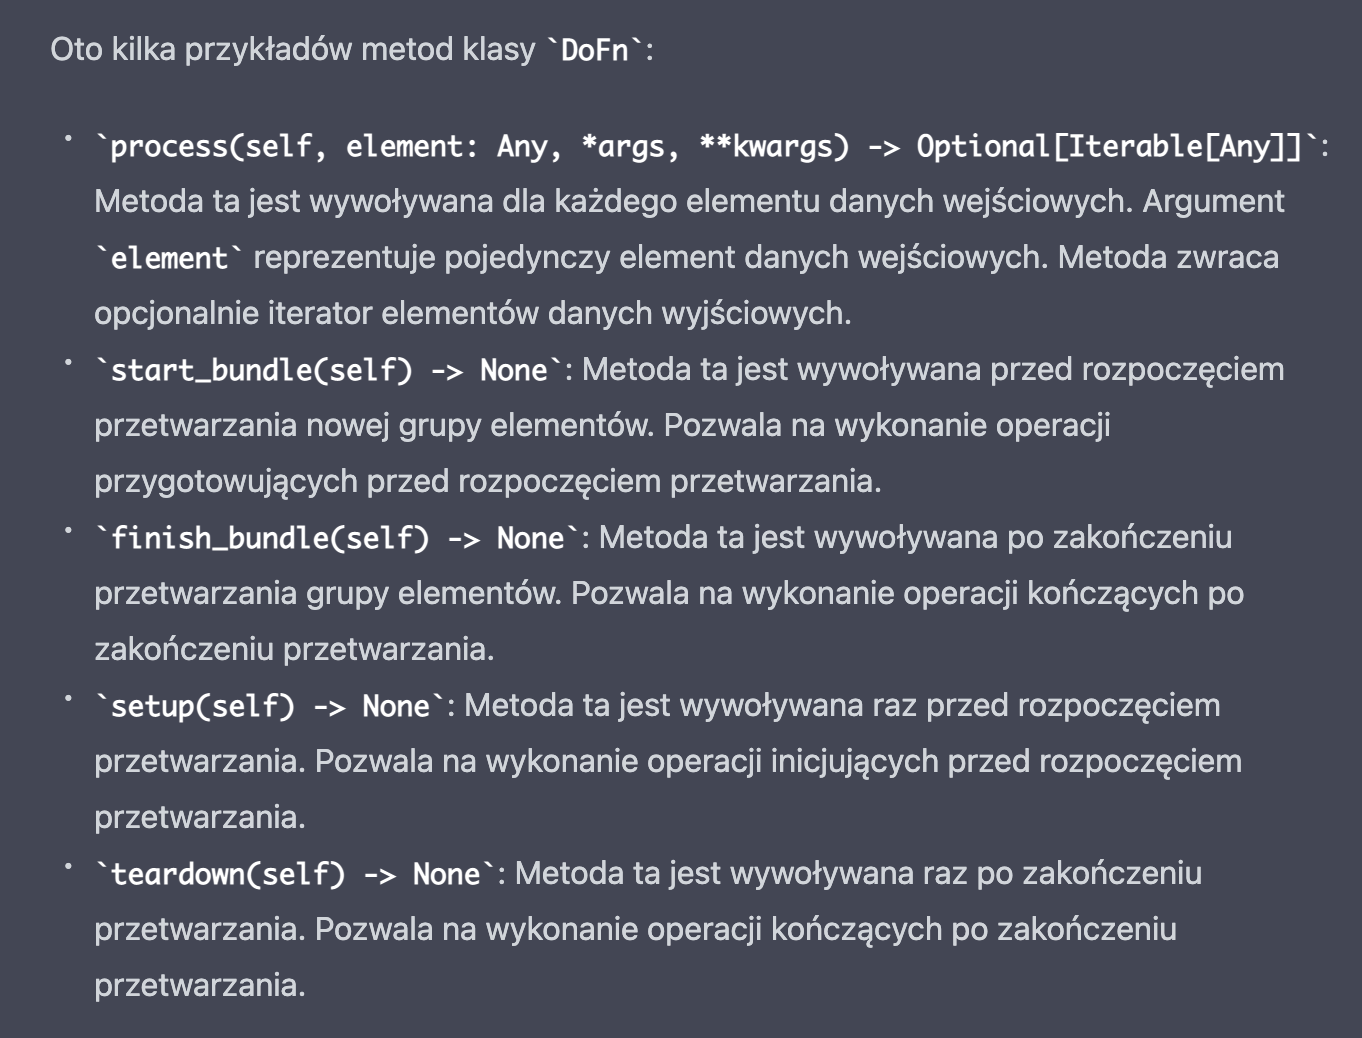

###beam.Filter & beam.Map

W poniższym kodzie tworzony jest `pipeline`, który składa się z dwóch transformacji. Najpierw tworzymy `PCollection` `input` z listy słowników `data`.

Następnie przetwarzamy tę `PCollection`, filtrując tylko osoby, których wiek jest większy niż 30, a następnie wybierając tylko ich imiona. Ostatecznie wyniki są wyświetlane za pomocą funkcji print.

In [ ]:
import apache_beam as beam

# Przykładowe dane
data = [
    {'name': 'Alice', 'age': 25},
    {'name': 'Bob', 'age': 30},
    {'name': 'Charlie', 'age': 35},
    {'name': 'David', 'age': 40},
    {'name': 'Eve', 'age': 45}
]

# Tworzymy pipeline
with beam.Pipeline(InteractiveRunner()) as p:
    # Tworzymy PCollection z danych wejściowych
    input = p | 'Create input data' >> beam.Create(data)

    # Przetwarzamy PCollection
    output = (
        input
        | 'Filter by age' >> beam.Filter(lambda x: x['age'] >= 30)
        | 'Get name' >> beam.Map(lambda x: x['name'])
    )

    # ib.show_graph(p)
    # ib.show(output)

    output | 'Print output' >> beam.Map(print)

Bob
Charlie
David
Eve


###beam.FlatMap & beam.Filter & beam.Map & beam.CombinePerKey

W tym przykładzie używamy modułu `ReadFromText` i `WriteToText`, aby wczytać dane z pliku tekstowego i zapisać wyniki do pliku tekstowego na `Google Cloud Storage`.

Następnie wykorzystujemy `FlatMap i Filter`, aby podzielić dane na słowa i usunąć krótkie słowa.

Następnie `Map i CombinePerKey` są używane, aby przypisać wartość 1 do każdego słowa i zsumować wartości dla każdego słowa. Ostatecznie wyniki są zapisywane do pliku tekstowego.

Ten przykład pokazuje, jak skorzystać z `PCollection` do przetwarzania danych tekstowych przy użyciu różnych transformacji.

In [ ]:
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io import ReadFromText, WriteToText

# Definiujemy pipeline options
options = PipelineOptions()

# Tworzymy pipeline
with beam.Pipeline(options=options) as p:
    # Wczytujemy dane z pliku tekstowego
    lines = p | 'ReadFromText' >> ReadFromText('gs://my-bucket/input.txt')

    # Dzielimy linie na słowa
    words = (
        lines
        | 'Split' >> beam.FlatMap(lambda line: line.split(' '))
        | 'FilterWords' >> beam.Filter(lambda word: len(word) > 3)
    )

    # Przypisujemy każdemu słowu wartość 1
    word_counts = (
        words
        | 'PairWithOne' >> beam.Map(lambda word: (word, 1))
        | 'GroupAndSum' >> beam.CombinePerKey(sum)
    )

    # Zapisujemy wyniki do pliku tekstowego
    word_counts | 'WriteToText' >> WriteToText('gs://my-bucket/output.txt')

###beam.Filter & beam.Map

In [ ]:
data = [
    {'name': 'Alice', 'age': 25, 'city': 'London'},
    {'name': 'Bob', 'age': 30, 'city': 'Paris'},
    {'name': 'Charlie', 'age': 35, 'city': 'Berlin'},
    {'name': 'Dave', 'age': 40, 'city': 'Madrid'},
    {'name': 'Eve', 'age': 45, 'city': 'Rome'},
]

# Tworzymy pipeline
with beam.Pipeline(InteractiveRunner()) as p:
    # Tworzymy PCollection z danych wejściowych
    input = p | 'Create input data' >> beam.Create(data)

    # Przetwarzamy PCollection
    output = (
        input
        | 'FilterLondon' >> beam.Filter(lambda row: row['city'] == 'London')
        | 'FormatOutput' >> beam.Map(lambda row: f"Name: {row['name']}, Age: {row['age']}")
    )

    # ib.show_graph(p)
    ib.show(output) # output | 'Print output' >> beam.Map(print)

###beam.Filter & beam.Map & beam.io.WriteToText

In [ ]:
options = PipelineOptions(
    runner='DirectRunner',
    project='my-gcp-project',
    temp_location='gs://my-bucket/tmp',
    region='europe-west1',
    staging_location='gs://my-bucket/staging'
)

p = beam.Pipeline(options=options)

data = [
    {'name': 'Alice', 'age': 25, 'city': 'London'},
    {'name': 'Bob', 'age': 30, 'city': 'Paris'},
    {'name': 'Charlie', 'age': 35, 'city': 'Berlin'},
    {'name': 'Dave', 'age': 40, 'city': 'Madrid'},
    {'name': 'Eve', 'age': 45, 'city': 'Rome'},
]

output_file = 'gs://my-bucket/output/results.txt'

(p | 'CreateData' >> beam.Create(data)
   | 'FilterLondon' >> beam.Filter(lambda row: row['city'] == 'London')
   | 'FormatOutput' >> beam.Map(lambda row: f"Name: {row['name']}, Age: {row['age']}")
   | 'WriteOutput' >> beam.io.WriteToText(output_file))

p.run().wait_until_finish()

###BigQuery

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io.gcp.internal.clients import bigquery
from apache_beam.io.gcp.bigquery import parse_table_schema_from_json

# Ustawienia opcji Dataflow
options = PipelineOptions.from_dictionary({
    "project": "my-project",
    "staging_location": "gs://my-bucket/staging",
    "temp_location": "gs://my-bucket/temp",
    "runner": "DataflowRunner",
    "region": "europe-west1"
})

# Zapytanie SQL do pobrania danych z BigQuery
query = """
    SELECT
        date,
        pagePath,
        deviceCategory,
        SUM(pageviews) AS pageviews
    FROM
        `my-project.dataset.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY))
        AND FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY))
    GROUP BY
        date,
        pagePath,
        deviceCategory
"""

# Schemat tabeli wynikowej
schema = parse_table_schema_from_json('''
    {
        "fields": [
            {"name": "date", "type": "DATE"},
            {"name": "pagePath", "type": "STRING"},
            {"name": "deviceCategory", "type": "STRING"},
            {"name": "pageviews", "type": "INTEGER"}
        ]
    }
''')

# Definicja funkcji przetwarzającej
class FormatData(beam.DoFn):
    def process(self, element):
        return [{
            "date": element["date"].strftime("%Y-%m-%d"),
            "pagePath": element["pagePath"],
            "deviceCategory": element["deviceCategory"],
            "pageviews": element["pageviews"]
        }]

# Pipeline
with beam.Pipeline(options=options) as p:
    # Pobranie danych z BigQuery
    rows = p | 'Read from BigQuery' >> beam.io.ReadFromBigQuery(query=query, use_standard_sql=True)

    # Przetwarzanie danych
    formatted_rows = (
        rows
        | 'Format Data' >> beam.ParDo(FormatData())
    )

    # Zapis danych do BigQuery
    formatted_rows | 'Write to BigQuery' >> beam.io.WriteToBigQuery(
        'my-project.dataset.table',
        schema=schema,
        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
    )

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io.gcp.analytics import ReadFromGoogleAnalytics
from apache_beam.io.gcp.bigquery import WriteToBigQuery
from apache_beam.io.gcp.bigquery import parse_table_schema_from_json
from datetime import datetime, timedelta

# Ustawienia opcji dla przepływu danych Dataflow
options = PipelineOptions(
    runner='DataflowRunner',
    project='YOUR_PROJECT_ID',
    region='YOUR_REGION',
    temp_location='gs://YOUR_BUCKET_NAME/temp',
    staging_location='gs://YOUR_BUCKET_NAME/staging'
)

# Definiowanie schematu tabeli BigQuery
schema = parse_table_schema_from_json('''
    [
        {"name": "date", "type": "DATE", "mode": "REQUIRED"},
        {"name": "channelGrouping", "type": "STRING", "mode": "REQUIRED"},
        {"name": "users", "type": "INTEGER", "mode": "REQUIRED"},
        {"name": "sessions", "type": "INTEGER", "mode": "REQUIRED"},
        {"name": "bounceRate", "type": "FLOAT", "mode": "REQUIRED"}
    ]
''')

# Konfiguracja zapytania do Google Analytics
query = {
    'ids': 'ga:YOUR_VIEW_ID',
    'metrics': 'ga:users,ga:sessions,ga:bounceRate',
    'dimensions': 'ga:date,ga:channelGrouping'
}

# Funkcja przetwarzająca dane z Google Analytics
def process_data(element):
    date = element['date']
    channel = element['channelGrouping']
    users = element['metrics']['ga:users']

    return [(date, channel, int(users))]


# Tworzenie i uruchamianie przepływu danych Dataflow
with beam.Pipeline(options=options) as pipeline:
    pipeline \
        | 'ReadFromGoogleAnalytics' >> ReadFromGoogleAnalytics(
            query,
            start_date=(datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d'),
            end_date=datetime.today().strftime('%Y-%m-%d'),
            sampling_level='LARGE'
        ) \
        | 'ProcessData' >> beam.FlatMap(process_data) \
        | 'WriteToBigQuery' >> WriteToBigQuery(
            table='YOUR_PROJECT_ID:YOUR_DATASET_NAME.new_table',
            schema=schema,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND
        )


In [ ]:
import argparse
import json
import logging

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.value_provider import StaticValueProvider


class ParseJson(beam.DoFn):
    def process(self, element):
        try:
            yield json.loads(element)
        except json.JSONDecodeError as e:
            logging.error(f'Error decoding element {element}: {e}')


class FilterEventType(beam.DoFn):
    def process(self, element, event_type):
        if element.get('eventCategory') == event_type:
            yield element


class ConvertTimestamp(beam.DoFn):
    def process(self, element):
        timestamp_micros = int(element.get('timestampMicros'))
        element['eventTimestamp'] = timestamp_micros // 1000000
        yield element


class FormatOutput(beam.DoFn):
    def process(self, element):
        yield {
            'event_category': element.get('eventCategory'),
            'event_action': element.get('eventAction'),
            'event_label': element.get('eventLabel'),
            'event_value': element.get('eventValue'),
            'event_timestamp': element.get('eventTimestamp')
        }


def run(argv=None):
    parser = argparse.ArgumentParser()

    parser.add_argument(
        '--project_id',
        help='Google Cloud project ID',
        required=True
    )
    parser.add_argument(
        '--input_topic',
        help='Google Cloud Pub/Sub topic to read from',
        required=True
    )
    parser.add_argument(
        '--event_type',
        help='The event category to filter on',
        required=True
    )
    parser.add_argument(
        '--output_table',
        help='BigQuery output table',
        required=True
    )

    known_args, pipeline_args = parser.parse_known_args(argv)

    pipeline_options = PipelineOptions(pipeline_args)

    with beam.Pipeline(options=pipeline_options) as p:
        (
            p
            | 'Read from Pub/Sub' >> beam.io.gcp.pubsub.ReadFromPubSub(
                subscription=known_args.input_topic
            )
            | 'Parse JSON' >> beam.ParDo(ParseJson())
            | 'Filter event type' >> beam.ParDo(
                FilterEventType(),
                event_type=StaticValueProvider(str, known_args.event_type)
            )
            | 'Convert timestamp' >> beam.ParDo(ConvertTimestamp())
            | 'Format output' >> beam.ParDo(FormatOutput())
            | 'Write to BigQuery' >> beam.io.WriteToBigQuery(
                known_args.output_table,
                schema='event_category:STRING,event_action:STRING,event_label:STRING,event_value:INTEGER,event_timestamp:TIMESTAMP',
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND
            )
        )


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()


W tym przykładzie mamy trzy transformacje `ParDo`, które generują wiele wyjść. Pierwsza transformacja `ParDo` `SplitEvents` dzieli dane wejściowe na pojedyncze wydarzenia, które są przechowywane w polu events obiektu wejściowego. Druga transformacja `ParDo` `ExtractEventData` wyodrębnia dane z każdego wydarzenia, takie jak nazwa, znacznik czasu i parametry, i generuje wiele wyników dla każdego wydarzenia. Następnie wyjścia tych dwóch transformacji są przekazywane do trzeciej transformacji `ParDo` `FilterEventsByName`, która filtrowuje wyniki na podstawie nazwy wydarzenia. Na końcu wyjścia tej transformacji są przekazywane do czwartej transformacji `ParDo` `PrintResults`, która drukuje wyniki do konsoli.

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

class SplitEvents(beam.DoFn):
  def process(self, element):
    events = element.get('events', [])
    for event in events:
      yield event

class ExtractEventData(beam.DoFn):
  def process(self, element):
    event_name = element.get('name', '')
    event_timestamp = element.get('timestampMicros', '')
    event_params = element.get('params', [])
    for param in event_params:
      key = param.get('key', '')
      value = param.get('value', '')
      yield {'event_name': event_name, 'event_timestamp': event_timestamp, 'param_key': key, 'param_value': value}

class FilterEventsByName(beam.DoFn):
  def __init__(self, event_name):
    self.event_name = event_name

  def process(self, element):
    if element['event_name'] == self.event_name:
      yield element

with beam.Pipeline(options=PipelineOptions()) as p:
  events = (p
            | 'Read from Pub/Sub' >> beam.io.gcp.pubsub.ReadFromPubSub(
              subscription='projects/<project>/subscriptions/<subscription>')
            | 'Parse JSON' >> beam.Map(lambda x: json.loads(x))
            )

  # Pierwsza transformacja ParDo, która dzieli dane wejściowe na pojedyncze wydarzenia.
  split_events = events | 'Split Events' >> beam.ParDo(SplitEvents())

  # Druga transformacja ParDo, która wyodrębnia dane z wydarzenia i generuje wiele wyników.
  extracted_data = split_events | 'Extract Event Data' >> beam.ParDo(ExtractEventData())

  # Trzecia transformacja ParDo, która filtruje wyniki na podstawie nazwy wydarzenia.
  filtered_events = extracted_data | 'Filter Events by Name' >> beam.ParDo(FilterEventsByName('my_event_name'))

  # Czwarta transformacja ParDo, która drukuje wyniki do konsoli.
  filtered_events | 'Print Results' >> beam.Map(print)

###beam.combiners.Count.PerKey

In [ ]:
with beam.Pipeline() as p:
    input_data = [
        ('apple', 1), ('orange', 1), ('apple', 1), ('banana', 1), ('banana', 1), ('orange', 1), ('pear', 1)
    ]
    data = p | 'Create data' >> beam.Create(input_data)

    count_per_key = data | 'Count per key' >> beam.combiners.Count.PerKey()

    # print the output of count_per_key
    _ = count_per_key | 'Print results' >> beam.Map(print)

('apple', 2)
('orange', 2)
('banana', 2)
('pear', 1)


###Pojedyncza transformacja ParDo dająca wiele wyjść

In [ ]:
class SplitWords(beam.DoFn):
  def process(self, element):
    words = element.split()
    for word in words:
      yield word

class CountCharacters(beam.DoFn):
  def process(self, element):
    yield len(element)

with beam.Pipeline(InteractiveRunner()) as p:
    input = p | beam.Create(['Hello World', 'Apache Beam', 'Google Cloud'])

    # Pierwsza transformacja ParDo, która dzieli wiersze na słowa.
    words = input | 'Split Words' >> beam.ParDo(SplitWords())

    # Druga transformacja ParDo, która zlicza liczbę znaków w każdym słowie.
    word_lengths = words | 'Count Characters' >> beam.ParDo(CountCharacters())
    ib.show(word_lengths)